In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('/home/tiurin/projects/ExampleProject/Temp/eye_quality/')

In [3]:
#|export
DATASET_PATH = "/home/tiurin/projects/ExampleProject/Temp"

In [4]:
#|export
from torch.utils.data import Dataset, Subset
import torch
import torchvision
import numpy as np

In [5]:
#|export
import os, glob
import random

class EyeQDataset(Dataset):

    def __init__(self, dataset_path, transform=None):
        self.transform = transform
        self.data = []
        random.seed(42)
        if not isinstance(dataset_path, list):
            dataset_path = [dataset_path]
        for p in dataset_path:
            for i in range(3):
                class_i = [(2-i, im) for im in glob.glob(os.path.join(p, str(i), '*.png'))]
                self.data.extend(class_i)

    def __len__(self):
        return len(self.data)

    def get_labels(self):
        return [i[0] for i in self.data]

    def __getitem__(self, idx):
        quality_class, image_path = self.data[idx]
        sample = torchvision.io.read_image(image_path).to(torch.float32)
        sample /= 255.0

        if self.transform:
            sample = self.transform(sample)

        return quality_class, sample

In [6]:
#|export
import os, glob
import random

class EyeQDatasetDistorted(Dataset):

    def __init__(self, dataset_path, transform=None):
        self.transform = transform
        self.data = []
        random.seed(42)
        if not isinstance(dataset_path, list):
            dataset_path = [dataset_path]
        for p in dataset_path:
            for i in range(3):
                class_i = [im for im in glob.glob(os.path.join(p, str(i), '*.png'))]
                self.data.extend(class_i)

        self.distortion_transforms=[
            #torchvision.transforms.ElasticTransform(alpha=[50., 250.0], sigma=[2., 10.]),
            torchvision.transforms.Normalize((0.856), (0.224)),
            torchvision.transforms.RandomResizedCrop((400, 400), scale=(0.08, 0.5), ratio=(0.75, 1.3)),
            #torchvision.transforms.ColorJitter(brightness=[0.5, 1.0], contrast=[0.5, 1.0], 
            #                                   saturation=[0.5, 1.0], hue=0.5),
            #torchvision.transforms.GaussianBlur(kernel_size=9, sigma=(10.0, 15.0))
        ]
        
        self.probability_apply = 0.0
        
                
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data[idx]
        sample = torchvision.io.read_image(image_path).to(torch.float32)
        sample /= 255.0
        
        tnsfm = random.choice(self.distortion_transforms)
        sample = tnsfm(sample)
        
        for i in range(len(self.distortion_transforms)-1):
            if random.uniform(0, 1) > self.probability_apply:
                tnsfm = random.choice(self.distortion_transforms)
                sample = tnsfm(sample)
        
        if random.uniform(0, 1) > self.probability_apply:
            sample += torch.rand_like(sample)
        
        if self.transform:
            sample = self.transform(sample)

        return 0, sample

In [7]:
#|export
import os, glob
import random

class EyeQDatasetRejectClass(Dataset):

    def __init__(self, dataset_path, transform=None):
        self.transform = transform
        self.data = []
        random.seed(42)
        if not isinstance(dataset_path, list):
            dataset_path = [dataset_path]
        for p in dataset_path:
            class_i = [im for im in glob.glob(os.path.join(p, '*.*'))]
            self.data.extend(class_i)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data[idx]
        sample = torchvision.io.read_image(image_path).to(torch.float32)
        sample /= 255.0

        if self.transform:
            sample = self.transform(sample)

        return 0, sample

In [8]:
#|export
import os, glob
import random

class RandomImages(Dataset):

    def __init__(self, dataset_path, transform=None):
        self.transform = transform
        self.data = []
        random.seed(42)
        if not isinstance(dataset_path, list):
            dataset_path = [dataset_path]
        for p in dataset_path:
            class_i = [im for im in glob.glob(os.path.join(p,  '**/*.jpg'), recursive=True)]
            self.data.extend(class_i)
            class_i = [im for im in glob.glob(os.path.join(p,  '**/*.jpeg'), recursive=True)]
            self.data.extend(class_i)
        self.gray_transform = torchvision.transforms.Grayscale()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data[idx]
        sample = torchvision.io.read_image(image_path).to(torch.float32)
        sample = self.gray_transform(sample)
        sample /= 255.0

        if self.transform:
            sample = self.transform(sample)

        return 0, sample

In [9]:
#|export
import os, glob
import random

class NoiseImages(Dataset):

    def __init__(self, dataset_size, image_size, transform=None):
        self.transform = transform
        self.dataset_size = dataset_size
        self.image_size = image_size
        random.seed(42)

    def __len__(self):
        return self.dataset_size

    def __getitem__(self, idx):
        
        if random.uniform(0, 1) > 0.5:
            sample = torch.randn(self.image_size)
            sample = (sample+sample.max())/sample.max()
        else:
            sample = torch.full(self.image_size, random.uniform(0, 1))
        
        if self.transform:
            sample = self.transform(sample)

        return 0, sample

In [10]:
#|export

def get_padding(image, height, width):
    max_w = width 
    max_h = height
    
    imsize = (image.size(1), image.size(2))
    h_padding = (max_w - imsize[0]) / 2
    v_padding = (max_h - imsize[1]) / 2
    l_pad = h_padding if h_padding % 1 == 0 else h_padding+0.5
    t_pad = v_padding if v_padding % 1 == 0 else v_padding+0.5
    r_pad = h_padding if h_padding % 1 == 0 else h_padding-0.5
    b_pad = v_padding if v_padding % 1 == 0 else v_padding-0.5
    
    padding = (int(l_pad), int(t_pad), int(r_pad), int(b_pad))
    
    return padding

In [11]:
#|export
import random
def zoom_augmentation(tensor):
    width = tensor.size(dim=2)
    height = tensor.size(dim=1)
    scale = random.uniform(0.6, 1)
    width_n = int(width*scale)
    height_n = int(height*scale)
    tensor = torchvision.transforms.functional.resize(tensor, (height_n, width_n))
    padding = get_padding(tensor, width, height)
    tensor = torchvision.transforms.functional.pad(tensor, padding)
    return tensor

In [32]:
#|export

from torch.utils.data import ConcatDataset

def get_dataset(train_percent = 0.9, rotation_transform=True, zoom_augment = True):
    
    transforms = []
    
    if rotation_transform:
        transforms.append(torchvision.transforms.RandomRotation(degrees=(0, 360)))
        
    transforms.append(torchvision.transforms.RandomHorizontalFlip(p=0.5))
    transforms.append(torchvision.transforms.RandomVerticalFlip(p=0.5))
    if zoom_augment:
        transforms.append(zoom_augmentation)
    transforms.append(torchvision.transforms.Resize((400,400)))
    #transforms.append(torchvision.transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1))
    #transforms.append(torchvision.transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.2)))
    transforms.append(torchvision.transforms.Normalize((0.456), (0.224)))
    
    transform = torchvision.transforms.Compose(transforms)
    
    dataset_paths = [os.path.join(DATASET_PATH, 'processed'),
                     os.path.join(DATASET_PATH, 'processed_test')]
    
    dataset = EyeQDataset(dataset_paths, transform=transform)
    
    dataset_noise = NoiseImages(2000, (1, 400,400), transform=transform)
    
    dataset_random = RandomImages(os.path.join(DATASET_PATH, 'trash_images'), transform=transform)
    
    lbls = np.asarray(dataset.get_labels())
    
    idx_train = []
    idx_val = []
    
    np.random.seed(42)
    for i in range(3):
        idx = np.where(lbls==i)[0]
        np.random.shuffle(idx)
        train_size = int(len(idx)*train_percent)
        val_size = len(idx)-train_size
        idx_train.extend(idx[:train_size].tolist())
        idx_val.extend(idx[train_size:].tolist())
    
    lbls = np.concatenate((lbls, np.asarray([0]*len(dataset_noise)), np.asarray([0]*len(dataset_random))))
    P = torch.bincount(torch.Tensor(lbls).to(torch.long))/len(lbls)
    class_weights = torch.sqrt(1/P)
    
    train_set = Subset(dataset, idx_train)
    
    #train_set = ConcatDataset([train_set, dataset_noise, dataset_random])
    
    val_set = Subset(dataset, idx_val)
    
    return train_set, val_set, class_weights

In [13]:
#|export
def normalize(tensor):
    return torchvision.transforms.functional.normalize(tensor,(0.456), (0.224))

In [14]:
#|export
def inverse_transform(tensor):
    tensor =  torchvision.transforms.functional.normalize(tensor, mean = [ 0.],std = [ 1/0.224])
    tensor =  torchvision.transforms.functional.normalize(tensor, mean = [-0.456],std = [1.])
    return tensor

In [15]:
#|export
def convert_to_image(tensor):
    tensor = inverse_transform(tensor)
    tensor = tensor.detach().cpu().numpy()*255
    tensor = tensor.astype('uint8')
    return tensor

In [16]:
#|export
def convert_for_predict(image):
    image = torchvision.transforms.functional.to_tensor(image)
    image = torchvision.transforms.functional.resize(image, (400,400) )
    image = torchvision.transforms.functional.normalize(image, (0.456), (0.224))
    return image

In [17]:
import matplotlib.pyplot as plt

In [33]:
ts, vs, cw = get_dataset(train_percent=0.9)

In [35]:
len(vs)

2880

In [36]:
len(ts)

25912

In [449]:
#|export
import cv2 as cv

def color_feature(image):
    return np.mean(image[image>0])

In [450]:
#|export
def moving_average_filter(img, size):
    kernel = np.ones((size, size), np.float32) / (size*size)
    filtered = cv2.filter2D(img, -1, kernel)
    return filtered

In [412]:
ddepth = cv.CV_16S
scale = 1
delta = 0

def sobel(image):
    
    grad_x = cv.Sobel(image, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv.BORDER_DEFAULT)
    grad_y = cv.Sobel(image, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv.BORDER_DEFAULT)
    
    abs_grad_x = cv.convertScaleAbs(grad_x)
    abs_grad_y = cv.convertScaleAbs(grad_y)
    
    grad = cv.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    
    return grad

In [413]:
def focus_features(image):
    FM1 = np.mean(sobel(image))
    
    fm2 = np.mean(sobel(moving_average_filter(image, 3)))
    FM2 = FM1 - fm2
    
    fm3 = np.mean(sobel(moving_average_filter(image, 5)))
    FM3 = fm2 - fm3
    
    return FM1, FM2, FM3

In [414]:
focus_features(image)

(8.3531125, 1.4776375000000002, 0.8226374999999999)

In [447]:
def illumination_features(image):
    non_zero_vals = image[image>0]
    IM1 = np.mean(non_zero_vals)
    IM2 = np.var(non_zero_vals[non_zero_vals<=IM1])
    IM3 = np.var(non_zero_vals[non_zero_vals>IM1])    
    IM4 = np.var(non_zero_vals)
    return IM1, IM2, IM3, IM4

In [448]:
illumination_features(image)

(78.15836072987877, 115.95398044933599, 1263.657099826435, 1257.3848611719661)

In [439]:
def contrast_features(image):
    hist = cv.calcHist(image, [0], None, [16], [1, 256])
    ct1 = np.abs(hist/np.sum(hist)-0.0625).sum()
    ct2 = (hist==0).sum()
    
    avgd = moving_average_filter(image, 3)
    hist = cv.calcHist(avgd, [0], None, [16], [1, 256])
    ct3 = np.abs(hist/np.sum(hist)-0.0625).sum()
    ct4 = (hist==0).sum()
    return ct1, ct2, ct3, ct4

In [440]:
contrast_features(image)

(1.093607, 0, 1.0900835, 0)

In [ ]:
from matplotlib import pyplot as plt

In [397]:
smpl = ts[-6]

In [398]:
smpl[0]

2

In [237]:
hist = cv.calcHist(image, [0], None, [256], [0, 256])

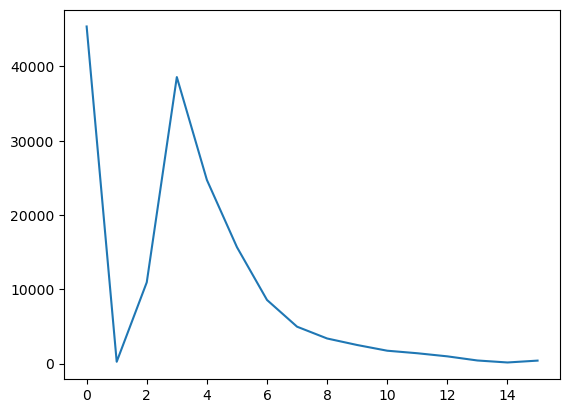

In [426]:
plt.plot(hist[0:])
#plt.xlim([0,256])
plt.show()

In [212]:
def calc_exposure(image):
    hist = cv.calcHist(image, [0], None, [256], [0, 256])
    flattened_image = image.flatten()
    flattened_image = flattened_image[flattened_image > 1]
    md = np.median(flattened_image)
    mn = np.mean(flattened_image)
    low_intens_limit = 1
    peak_intensity = low_intens_limit + np.argmax(hist[low_intens_limit:])
    
    return md, mn, peak_intensity

In [213]:
def compare(main_intensity):
    return 70 <= main_intensity < 130

In [368]:
smpl = ts[-6]
image = convert_to_image(smpl[1])
calc_exposure(image)

(67.0, 78.07255110694116, 53)

In [396]:
def get_image_mask(image):
    img = image.transpose((1, 2, 0)).copy()
    ret, thresh1 = cv.threshold(img, 0, 255, cv.THRESH_BINARY)
    contours, _ = cv.findContours(thresh1, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    img = cv.drawContours(img, contours, -1, (255), -1)
    ret, img = cv.threshold(img, 0, 255, cv.THRESH_BINARY)
    return img

In [389]:
img = get_image_mask(image)

In [390]:
np.mean(image[image>0])

78.03919057839018

In [391]:
np.mean(img*image)

61.67120625

In [335]:
image.shape

(1, 400, 400)

In [333]:
(image-img).max()

255

In [340]:
img = np.expand_dims(img,0)

In [341]:
img.shape

(1, 400, 400)

In [346]:
np.reshape(img[image == 0], (400, 400, 1))

ValueError: cannot reshape array of size 94868 into shape (400,400,1)

In [374]:
ret,thresh1 = cv.threshold(image, 0, 255, cv.THRESH_BINARY)

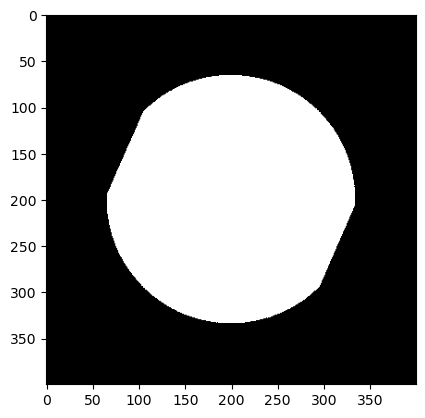

In [376]:
plt.imshow((thresh1).transpose((1, 2, 0)), cmap='gray', vmin=0, vmax=255)

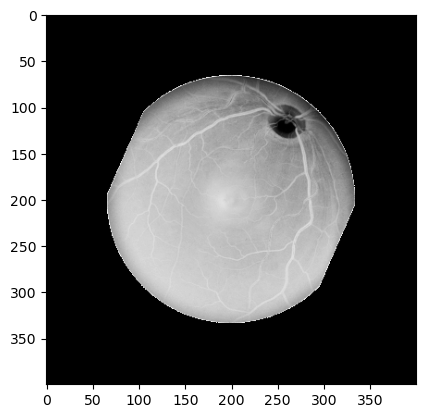

In [393]:
plt.imshow((img-image).transpose((1, 2, 0)), cmap='gray', vmin=0, vmax=255)

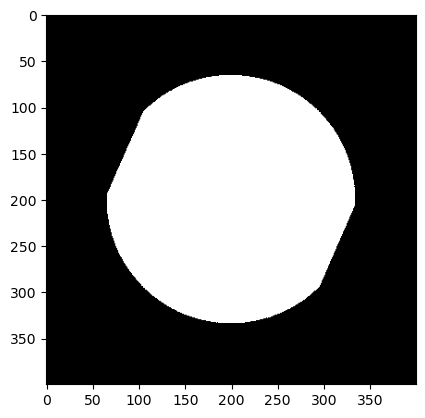

In [392]:
plt.imshow(img, cmap='gray')

In [226]:
for i, smpl in enumerate(reversed(ts)):
    dcls = smpl[0]
    if dcls == 0: continue
    image = convert_to_image(smpl[1])
    md, mn, pk = calc_exposure(image)
    md_r, mn_r, pk_r = compare(md), compare(mn), compare(pk)
    
    if md_r != mn_r or md_r != pk_r:
        print(i, dcls)

5 2
18 2
21 2
24 2
34 2
35 2
36 2
40 2
41 2
45 2
46 2
49 2
53 2
54 2
65 2
78 2
79 2
84 2
94 2
99 2
104 2
106 2
115 2
118 2
123 2
126 2
127 2
133 2


KeyboardInterrupt: 

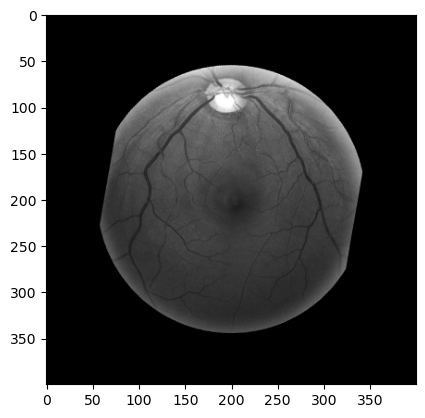

In [241]:
plt.imshow(image.transpose(1,2,0),cmap='gray')

In [32]:
#|default_exp dataset_utils
#|hide
nbpath = '/home/tiurin/projects/ExampleProject/Temp/code/nbs/dataset_utils.ipynb'
import nbdev; nbdev.nbdev_export(nbpath)